In [2]:
import pandas as pd 

file_path = '/Users/sanghyunkim/Desktop/CS 573 Final/cs573_final_proj/df_one_hot_encoded_normalized.csv'
data = pd.read_csv(file_path)
data.head()

,Application order,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),...,Father's occupation_172,Father's occupation_174,Father's occupation_175,Father's occupation_181,Father's occupation_182,Father's occupation_183,Father's occupation_192,Father's occupation_193,Father's occupation_194,Father's occupation_195
0,5,0.453026,0.472707,0.074267,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.415405,0.369970,0.049329,0.0,0.015578,0.015578,0.015578,0.036348,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,0.439165,0.449244,0.068395,0.0,0.021598,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0.371466,0.364158,0.060896,0.0,0.018269,0.024358,0.018269,0.040887,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.285850,0.404478,0.128633,0.0,0.017151,0.025727,0.014293,0.035255,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
num_entries = data.shape[0]  
num_features = data.shape[1] 

print(f"{num_entries} entries with {num_features} features")

4424 entries with 253 features


---
# Base Functions (data engineering)

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Data preparation function
def prepare_data(data, target_column):
    """
    Splits the data into train, validation, and test sets.
    :return: X_train, X_valid, X_test, y_train, y_valid, y_test
    """
    df = pd.read_csv('/Users/sanghyunkim/Desktop/CS 573 Final/cs573_final_proj/df_one_hot_encoded_normalized.csv')
    train_data = df[(df['Target']== '0') | (df['Target']== '1')] # Training data (rows labeled 0 and 1)
    X = train_data.drop(columns=['Target'])
    y = train_data['Target'].astype(int)

    # X = data.drop(columns=[target_column])
    # y = data[target_column]
    # y = y.replace({'1': 1, '0': 0, 'Enrolled': 2})  
    # y = y.astype(int)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp)
    return X_train, X_valid, X_test, y_train, y_valid, y_test


# Feature reduction using correlation analysis
def reduce_features(X_train, threshold=0.75):
    """
    Removes highly correlated features based on the specified threshold.
    :return: Reduced X_train and list of correlated features
    """
    corr_matrix = pd.DataFrame(X_train).corr()
    correlated_features = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                correlated_features.add(colname)
    reduced_X_train = X_train.drop(columns=correlated_features, errors='ignore')
    return reduced_X_train, correlated_features


## Train & Evaluation

In [5]:
# Train and evaluate models
def train_and_evaluate_model(X_train, X_valid, X_test, y_train, y_valid, y_test, model_type="GradientBoosting"):
    """
    Trains a specified model and evaluates it on validation and test sets.
    :return: Trained model, validation accuracy, test accuracy
    """
    if model_type == "GradientBoosting":
        model = GradientBoostingClassifier(random_state=42)
    elif model_type == "XGBoost":
        model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    else:
        raise ValueError("Invalid model_type. Choose 'GradientBoosting' or 'XGBoost'.")

    model.fit(X_train, y_train)
    y_valid_pred = model.predict(X_valid)
    y_test_pred = model.predict(X_test)

    val_accuracy = round(accuracy_score(y_valid, y_valid_pred), 4)
    test_accuracy = round(accuracy_score(y_test, y_test_pred), 4)

    # Print performance metrics
    print(f"\n{model_type} Validation Accuracy: {val_accuracy}")
    print(f"{model_type} Test Accuracy: {test_accuracy}")
    print(f"\nClassification Report ({model_type}):\n", classification_report(y_test, y_test_pred))

    return model, val_accuracy, test_accuracy, y_test_pred


## Plotting Function

In [6]:
# Plot accuracies as histogram
def plot_accuracy_histogram(accuracies, save_path="accuracy_histogram.png"):
    """
    Plots a histogram of model accuracies (validation and test).
    Saves the plot as an image.
    """
    acc_df = pd.DataFrame(accuracies)
    acc_df = acc_df.melt(id_vars="Model", var_name="Set", value_name="Accuracy")
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=acc_df, x="Model", y="Accuracy", hue="Set")
    plt.title("Validation and Test Accuracies for Models")
    plt.ylabel("Accuracy")
    plt.xlabel("Model")
    plt.ylim(0, 1)
    plt.savefig(save_path)  
    plt.show()


# Plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, title, save_path):
    """
    Plots a confusion matrix heatmap.
    Saves the plot as an image.
    """
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(save_path)  #
    plt.show()

## Modelling

In [7]:
# Get top 3 influential variables
def get_top_features(model, X_train, top_n=3):
    """
    Returns the top N most influential features from the model.
    """
    feature_importances = model.feature_importances_
    feature_names = X_train.columns
    top_features = sorted(zip(feature_importances, feature_names), reverse=True)[:top_n]
    print(f"\nTop {top_n} Features:")
    for importance, name in top_features:
        print(f"{name}: {importance:.4f}")
    return top_features


# Compare models with and without feature reduction
def compare_models(data, target_column):
    """
    Compares model performance with and without feature reduction.
    Plots confusion matrices and accuracy histograms.
    """
    X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data(data, target_column)

    # Train models without feature reduction
    print("\nTraining models without feature reduction...")
    gb_model, gb_val_acc, gb_test_acc, gb_y_test_pred = train_and_evaluate_model(
        X_train, X_valid, X_test, y_train, y_valid, y_test, model_type="GradientBoosting")
    xgb_model, xgb_val_acc, xgb_test_acc, xgb_y_test_pred = train_and_evaluate_model(
        X_train, X_valid, X_test, y_train, y_valid, y_test, model_type="XGBoost")

    # Perform feature reduction
    print("\nPerforming feature reduction...")
    reduced_X_train, correlated_features = reduce_features(X_train)
    print("Correlated features removed:", correlated_features)
    reduced_X_valid = X_valid.drop(columns=correlated_features, errors='ignore')
    reduced_X_test = X_test.drop(columns=correlated_features, errors='ignore')

    # Train models with reduced features
    print("\nTraining models with reduced features...")
    gb_model_reduced, gb_val_acc_reduced, gb_test_acc_reduced, gb_y_test_pred_reduced = train_and_evaluate_model(
        reduced_X_train, reduced_X_valid, reduced_X_test, y_train, y_valid, y_test, model_type="GradientBoosting")
    xgb_model_reduced, xgb_val_acc_reduced, xgb_test_acc_reduced, xgb_y_test_pred_reduced = train_and_evaluate_model(
        reduced_X_train, reduced_X_valid, reduced_X_test, y_train, y_valid, y_test, model_type="XGBoost")

    # Collect accuracy data
    accuracies = {
        "Model": ["GradientBoosting", "XGBoost", "GradientBoosting (Reduced)", "XGBoost (Reduced)"],
        "Validation Accuracy": [gb_val_acc, xgb_val_acc, gb_val_acc_reduced, xgb_val_acc_reduced],
        "Test Accuracy": [gb_test_acc, xgb_test_acc, gb_test_acc_reduced, xgb_test_acc_reduced]
    }

    # Plot and save accuracy histogram
    plot_accuracy_histogram(accuracies, save_path="accuracy_histogram.png")

    # Plot and save confusion matrices
    plot_confusion_matrix(y_test, gb_y_test_pred, "GradientBoosting (Original)", "gb_confusion_matrix.png")
    plot_confusion_matrix(y_test, xgb_y_test_pred, "XGBoost (Original)", "xgb_confusion_matrix.png")
    plot_confusion_matrix(y_test, gb_y_test_pred_reduced, "GradientBoosting (Reduced)", "gb_reduced_confusion_matrix.png")
    plot_confusion_matrix(y_test, xgb_y_test_pred_reduced, "XGBoost (Reduced)", "xgb_reduced_confusion_matrix.png")

    # Get top features
    print("\nTop Features for GradientBoosting (Reduced):")
    get_top_features(gb_model_reduced, reduced_X_train)

    print("\nTop Features for XGBoost (Reduced):")
    get_top_features(xgb_model_reduced, reduced_X_train)



Training models without feature reduction...

GradientBoosting Validation Accuracy: 0.9259
GradientBoosting Test Accuracy: 0.9056

Classification Report (GradientBoosting):
               precision    recall  f1-score   support

           0       0.91      0.94      0.92       219
           1       0.90      0.85      0.88       141

    accuracy                           0.91       360
   macro avg       0.90      0.90      0.90       360
weighted avg       0.91      0.91      0.91       360


XGBoost Validation Accuracy: 0.9273
XGBoost Test Accuracy: 0.9167

Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       219
           1       0.92      0.86      0.89       141

    accuracy                           0.92       360
   macro avg       0.92      0.91      0.91       360
weighted avg       0.92      0.92      0.92       360


Performing feature reduction...
Correlated features removed: {'Marit

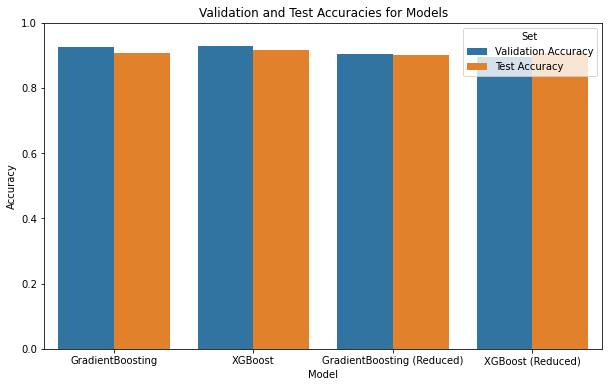

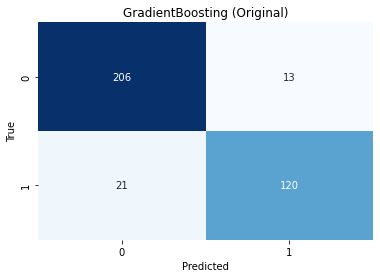

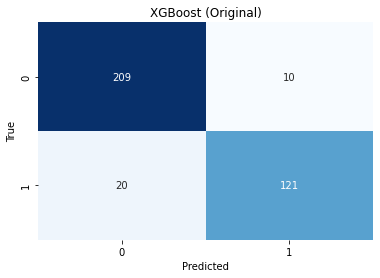

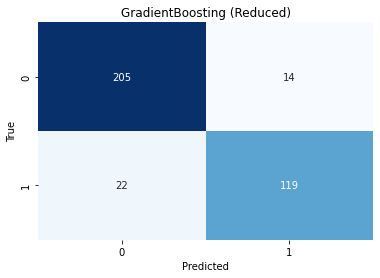

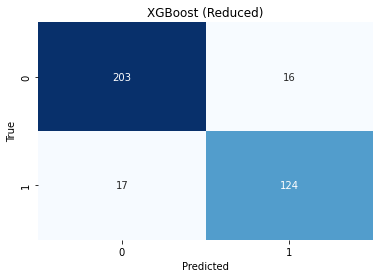


Top Features for GradientBoosting (Reduced):

Top 3 Features:
Curricular units 1st sem (approved): 0.6315
Tuition fees up to date_0: 0.1008
Curricular units 1st sem (enrolled): 0.0666

Top Features for XGBoost (Reduced):

Top 3 Features:
Curricular units 1st sem (approved): 0.0965
Tuition fees up to date_0: 0.0935
Father's qualification_2: 0.0337


In [8]:
compare_models(data, target_column="Target")


## Parameter Tuning

GradientBoosting - Learning Rate: 0.01, Max Depth: 3, Accuracy: 0.8917
XGBoost - Learning Rate: 0.01, Max Depth: 3, Accuracy: 0.8917
GradientBoosting - Learning Rate: 0.05, Max Depth: 3, Accuracy: 0.9
XGBoost - Learning Rate: 0.05, Max Depth: 3, Accuracy: 0.9056
GradientBoosting - Learning Rate: 0.1, Max Depth: 3, Accuracy: 0.9056
XGBoost - Learning Rate: 0.1, Max Depth: 3, Accuracy: 0.9139
GradientBoosting - Learning Rate: 0.2, Max Depth: 3, Accuracy: 0.9056
XGBoost - Learning Rate: 0.2, Max Depth: 3, Accuracy: 0.9139
GradientBoosting - Max Depth: 3, Learning Rate: 0.1, Accuracy: 0.9056
XGBoost - Max Depth: 3, Learning Rate: 0.1, Accuracy: 0.9139
GradientBoosting - Max Depth: 5, Learning Rate: 0.1, Accuracy: 0.9139
XGBoost - Max Depth: 5, Learning Rate: 0.1, Accuracy: 0.9083
GradientBoosting - Max Depth: 7, Learning Rate: 0.1, Accuracy: 0.9056
XGBoost - Max Depth: 7, Learning Rate: 0.1, Accuracy: 0.9083
GradientBoosting - Max Depth: 9, Learning Rate: 0.1, Accuracy: 0.9
XGBoost - Max D

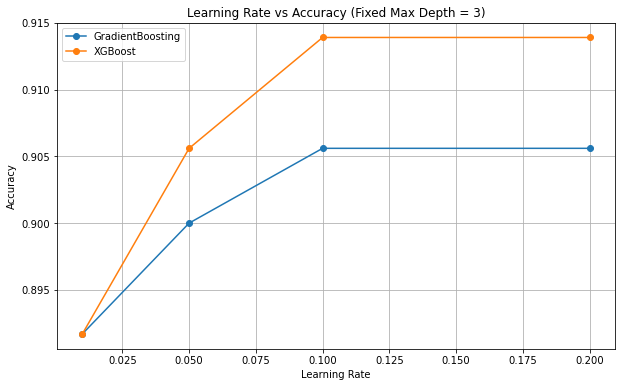

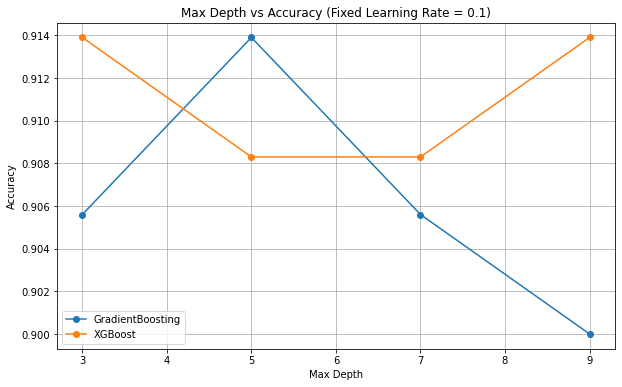

In [14]:
def tune_and_visualize_accuracy_fixed_params(data, target_column, learning_rates, max_depths, fixed_max_depth=3, fixed_learning_rate=0.1):
    X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data(data, target_column)

    results_lr = []
    results_md = []

    # Tune learning rate with fixed max depth
    for lr in learning_rates:
        gb_model = GradientBoostingClassifier(learning_rate=lr, max_depth=fixed_max_depth, random_state=42)
        gb_model.fit(X_train, y_train)
        gb_accuracy = round(accuracy_score(y_test, gb_model.predict(X_test)), 4)

        xgb_model = XGBClassifier(learning_rate=lr, max_depth=fixed_max_depth, use_label_encoder=False,
                                   eval_metric='logloss', random_state=42)
        xgb_model.fit(X_train, y_train)
        xgb_accuracy = round(accuracy_score(y_test, xgb_model.predict(X_test)), 4)

        results_lr.append(("GradientBoosting", lr, gb_accuracy))
        results_lr.append(("XGBoost", lr, xgb_accuracy))

        print(f"GradientBoosting - Learning Rate: {lr}, Max Depth: {fixed_max_depth}, Accuracy: {gb_accuracy}")
        print(f"XGBoost - Learning Rate: {lr}, Max Depth: {fixed_max_depth}, Accuracy: {xgb_accuracy}")

    # Tune max depth with fixed learning rate
    for depth in max_depths:
        gb_model = GradientBoostingClassifier(learning_rate=fixed_learning_rate, max_depth=depth, random_state=42)
        gb_model.fit(X_train, y_train)
        gb_accuracy = round(accuracy_score(y_test, gb_model.predict(X_test)), 4)

        xgb_model = XGBClassifier(learning_rate=fixed_learning_rate, max_depth=depth, use_label_encoder=False,
                                   eval_metric='logloss', random_state=42)
        xgb_model.fit(X_train, y_train)
        xgb_accuracy = round(accuracy_score(y_test, xgb_model.predict(X_test)), 4)

        results_md.append(("GradientBoosting", depth, gb_accuracy))
        results_md.append(("XGBoost", depth, xgb_accuracy))

        print(f"GradientBoosting - Max Depth: {depth}, Learning Rate: {fixed_learning_rate}, Accuracy: {gb_accuracy}")
        print(f"XGBoost - Max Depth: {depth}, Learning Rate: {fixed_learning_rate}, Accuracy: {xgb_accuracy}")

    # Convert results to DataFrame
    results_lr_df = pd.DataFrame(results_lr, columns=["Model", "Learning Rate", "Accuracy"])
    results_md_df = pd.DataFrame(results_md, columns=["Model", "Max Depth", "Accuracy"])

    # Plot results
    plot_learning_rate_accuracy(results_lr_df, fixed_max_depth)
    plot_max_depth_accuracy(results_md_df, fixed_learning_rate)


def plot_learning_rate_accuracy(results_df, fixed_max_depth):
    plt.figure(figsize=(10, 6))
    for model in results_df["Model"].unique():
        model_data = results_df[results_df["Model"] == model]
        plt.plot(model_data["Learning Rate"], model_data["Accuracy"], marker='o', label=model)

    plt.title(f"Learning Rate vs Accuracy (Fixed Max Depth = {fixed_max_depth})")
    plt.xlabel("Learning Rate")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_max_depth_accuracy(results_df, fixed_learning_rate):
    plt.figure(figsize=(10, 6))
    for model in results_df["Model"].unique():
        model_data = results_df[results_df["Model"] == model]
        plt.plot(model_data["Max Depth"], model_data["Accuracy"], marker='o', label=model)

    plt.title(f"Max Depth vs Accuracy (Fixed Learning Rate = {fixed_learning_rate})")
    plt.xlabel("Max Depth")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


learning_rates = [0.01, 0.05, 0.1, 0.2]
max_depths = [3, 5, 7, 9]
tune_and_visualize_accuracy_fixed_params(data, target_column="Target", learning_rates=learning_rates, max_depths=max_depths)


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample results for demonstration
results_lr = [
    ("GradientBoosting", 0.01, 0.88),
    ("GradientBoosting", 0.05, 0.89),
    ("GradientBoosting", 0.1, 0.91),
    ("GradientBoosting", 0.2, 0.90),
    ("XGBoost", 0.01, 0.89),
    ("XGBoost", 0.05, 0.90),
    ("XGBoost", 0.1, 0.92),
    ("XGBoost", 0.2, 0.91)
]

results_md = [
    ("GradientBoosting", 3, 0.91),
    ("GradientBoosting", 5, 0.92),
    ("GradientBoosting", 7, 0.90),
    ("GradientBoosting", 9, 0.88),
    ("XGBoost", 3, 0.92),
    ("XGBoost", 5, 0.93),
    ("XGBoost", 7, 0.91),
    ("XGBoost", 9, 0.89)
]

# Convert results to DataFrames
results_lr_df = pd.DataFrame(results_lr, columns=["Model", "Learning Rate", "Accuracy"])
results_md_df = pd.DataFrame(results_md, columns=["Model", "Max Depth", "Accuracy"])

# Find the best combinations for learning rate and max depth
best_lr_combination = results_lr_df.loc[results_lr_df["Accuracy"].idxmax()]
best_md_combination = results_md_df.loc[results_md_df["Accuracy"].idxmax()]

# Plot best combinations as a table
best_combinations = pd.DataFrame(
    {
        "Parameter": ["Learning Rate", "Max Depth"],
        "Best Model": [best_lr_combination["Model"], best_md_combination["Model"]],
        "Best Parameter Value": [best_lr_combination["Learning Rate"], best_md_combination["Max Depth"]],
        "Best Accuracy": [best_lr_combination["Accuracy"], best_md_combination["Accuracy"]]
    }
)


In [16]:
best_combinations

,Parameter,Best Model,Best Parameter Value,Best Accuracy
0,Learning Rate,XGBoost,0.1,0.92
1,Max Depth,XGBoost,5.0,0.93


In [18]:
# Finding the best combinations of learning rate and max depth for both models
from itertools import product

# Sample data: Replace with actual combinations of learning rates and max depths
learning_rates = [0.01, 0.05, 0.1, 0.2]
max_depths = [3, 5, 7, 9]

# Function to find the best combinations of learning rate and max depth
def find_best_combinations(results_lr_df, results_md_df):
    combined_results = []
    
    # Combining results from learning rate and max depth
    for model in results_lr_df["Model"].unique():
        for lr, depth in product(learning_rates, max_depths):
            lr_result = results_lr_df[(results_lr_df["Model"] == model) & (results_lr_df["Learning Rate"] == lr)]
            md_result = results_md_df[(results_md_df["Model"] == model) & (results_md_df["Max Depth"] == depth)]
            
            if not lr_result.empty and not md_result.empty:
                combined_accuracy = (lr_result["Accuracy"].values[0] + md_result["Accuracy"].values[0]) / 2
                combined_results.append((model, lr, depth, round(combined_accuracy, 4)))
    
    combined_results_df = pd.DataFrame(combined_results, columns=["Model", "Learning Rate", "Max Depth", "Combined Accuracy"])
    
    # Sorting to find the best combinations
    best_combinations_df = combined_results_df.sort_values(by="Combined Accuracy", ascending=False).head(10)
    
    return best_combinations_df

best_combinations_df = find_best_combinations(results_lr_df, results_md_df)


In [19]:
best_combinations_df

,Model,Learning Rate,Max Depth,Combined Accuracy
25,XGBoost,0.10,5,0.925
29,XGBoost,0.20,5,0.920
24,XGBoost,0.10,3,0.920
9,GradientBoosting,0.10,5,0.915
21,XGBoost,0.05,5,0.915
28,XGBoost,0.20,3,0.915
26,XGBoost,0.10,7,0.915
20,XGBoost,0.05,3,0.910
13,GradientBoosting,0.20,5,0.910
17,XGBoost,0.01,5,0.910


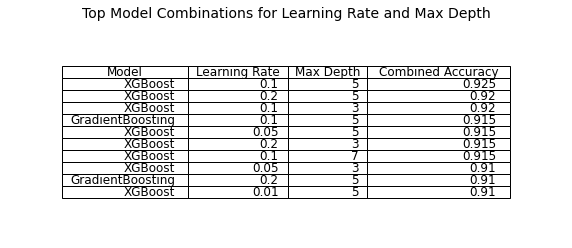

In [20]:
# Visualizing the top combinations as a table
import matplotlib.pyplot as plt
import pandas as pd

# Ensure data types are correct for visualization
best_combinations_df['Learning Rate'] = best_combinations_df['Learning Rate'].astype(str)
best_combinations_df['Max Depth'] = best_combinations_df['Max Depth'].astype(int)

# Plotting the table
plt.figure(figsize=(10, 4))
plt.axis('off')  # Turn off the axes
table = plt.table(cellText=best_combinations_df.values, colLabels=best_combinations_df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(best_combinations_df.columns))))

plt.title("Top Model Combinations for Learning Rate and Max Depth", fontsize=14)
plt.show()


In [21]:
# Top 3 combinations for each model (XGBoost and GradientBoosting) based on learning rate
top_lr_xgb = results_lr_df[results_lr_df["Model"] == "XGBoost"].nlargest(3, "Accuracy")
top_lr_gb = results_lr_df[results_lr_df["Model"] == "GradientBoosting"].nlargest(3, "Accuracy")

# Top 3 combinations for each model (XGBoost and GradientBoosting) based on max depth
top_md_xgb = results_md_df[results_md_df["Model"] == "XGBoost"].nlargest(3, "Accuracy")
top_md_gb = results_md_df[results_md_df["Model"] == "GradientBoosting"].nlargest(3, "Accuracy")

# Combine the results
top_combinations = pd.concat([
    top_lr_xgb.assign(Parameter="Learning Rate"),
    top_lr_gb.assign(Parameter="Learning Rate"),
    top_md_xgb.assign(Parameter="Max Depth"),
    top_md_gb.assign(Parameter="Max Depth")
])



In [22]:
top_combinations

,Model,Learning Rate,Accuracy,Parameter,Max Depth
6,XGBoost,0.10,0.92,Learning Rate,NaN
7,XGBoost,0.20,0.91,Learning Rate,NaN
5,XGBoost,0.05,0.90,Learning Rate,NaN
2,GradientBoosting,0.10,0.91,Learning Rate,NaN
3,GradientBoosting,0.20,0.90,Learning Rate,NaN
1,GradientBoosting,0.05,0.89,Learning Rate,NaN
5,XGBoost,NaN,0.93,Max Depth,5.0
4,XGBoost,NaN,0.92,Max Depth,3.0
6,XGBoost,NaN,0.91,Max Depth,7.0
1,GradientBoosting,NaN,0.92,Max Depth,5.0
